In [1]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'tar' is not recognized as an internal or external command,
operable program or batch file.


^C


Traceback (most recent call last):
  File "C:\Users\fuzzy\anaconda3\Scripts\pip-script.py", line 6, in <module>
    from pip._internal.cli.main import main
  File "C:\Users\fuzzy\anaconda3\lib\site-packages\pip\_internal\cli\main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "C:\Users\fuzzy\anaconda3\lib\site-packages\pip\_internal\cli\autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "C:\Users\fuzzy\anaconda3\lib\site-packages\pip\_internal\cli\main_parser.py", line 8, in <module>
    from pip._internal.cli import cmdoptions
  File "C:\Users\fuzzy\anaconda3\lib\site-packages\pip\_internal\cli\cmdoptions.py", line 23, in <module>
    from pip._internal.cli.parser import ConfigOptionParser
  File "C:\Users\fuzzy\anaconda3\lib\site-packages\pip\_internal\cli\parser.py", line 12, in <module>
    from pip._internal.configuration import Configuration, ConfigurationError
  File "C:\

Exception: Unable to find py4j in /content/spark-3.0.3-bin-hadoop2.7\python, your SPARK_HOME may not be configured correctly

In [31]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2022-02-17 23:54:32--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.1’

postgresql-42.2.16. 100%[===================>] 979.38K  4.58MB/s    in 0.2s    

2022-02-17 23:54:33 (4.58 MB/s) - ‘postgresql-42.2.16.jar.1’ saved [1002883/1002883]



In [32]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("M16-Amazon-Challenge2").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [33]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Furniture_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding","UTF-8").csv(SparkFiles.get("amazon_reviews_us_Furniture_v1_00.tsv.gz"), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   24509695|R3VR960AHLFKDV|B004HB5E0E|     488241329|Shoal Creek Compu...|       Furniture|          4|            0|          0|   N|                Y|... desk is very ...|This desk is very...| 2015-08-31|
|         US|   34731776|R16LGVMFKIUT0G|B0042TNMMS|     205864445|Dorel Home Produc...|       Furniture|          5|    

In [34]:
# Checking that the data types are correct
df.dtypes

[('marketplace', 'string'),
 ('customer_id', 'int'),
 ('review_id', 'string'),
 ('product_id', 'string'),
 ('product_parent', 'int'),
 ('product_title', 'string'),
 ('product_category', 'string'),
 ('star_rating', 'int'),
 ('helpful_votes', 'int'),
 ('total_votes', 'int'),
 ('vine', 'string'),
 ('verified_purchase', 'string'),
 ('review_headline', 'string'),
 ('review_body', 'string'),
 ('review_date', 'string')]

In [35]:
# Getting reviews with total_vote count that is >=20
greaterThan20 = df.filter("total_votes>=20")
greaterThan20.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   41681546| RL8D0KJ0J9L0O|B00BWC1X3S|     328960153|Zinus 14 Inch Eli...|       Furniture|          5|          152|        165|   N|                Y|A solid VICTORY f...|I've been looking...| 2015-08-31|
|         US|   16806846|R1BEINAIQFBRJC|B007I81A60|      68465765|8" Night Therapy ...|       Furniture|          5|    

In [36]:
greaterThan20.count()

18739

In [37]:
helpfulVotes = greaterThan20.filter("helpful_votes/total_votes >=0.5")
helpfulVotes.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   41681546| RL8D0KJ0J9L0O|B00BWC1X3S|     328960153|Zinus 14 Inch Eli...|       Furniture|          5|          152|        165|   N|                Y|A solid VICTORY f...|I've been looking...| 2015-08-31|
|         US|   16806846|R1BEINAIQFBRJC|B007I81A60|      68465765|8" Night Therapy ...|       Furniture|          5|    

In [38]:
helpfulVotes.count()

18155

In [39]:
# Creating a Datafram contain those that are PAID Vine program users
# Success can be confirmed by looking at the "vine" column values (They will all be "Y")
vinePaidDf = helpfulVotes.filter("vine=='Y'")
vinePaidDf.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   35119071|R2BQOD1R0228FN|B00H2RSA88|     405483618|Sleep Innovations...|       Furniture|          3|           17|         26|   Y|                N|An okay product. ...|Three-stars is co...| 2015-08-27|
|         US|   44737123| RC31RUPFOHBHQ|B0125QZ50G|     350975212|Zinus Viscolatex ...|       Furniture|          4|    

In [40]:
# Creating a Datafram contain those that are UNPAID Vine program users
# Success can be confirmed by looking at the "vine" column values (They will all be "N")
vineUnpaidDf = helpfulVotes.filter("vine=='N'")
vineUnpaidDf.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   41681546| RL8D0KJ0J9L0O|B00BWC1X3S|     328960153|Zinus 14 Inch Eli...|       Furniture|          5|          152|        165|   N|                Y|A solid VICTORY f...|I've been looking...| 2015-08-31|
|         US|   16806846|R1BEINAIQFBRJC|B007I81A60|      68465765|8" Night Therapy ...|       Furniture|          5|    

In [41]:
# Getting the total count of unpaid and paid vine users
totalReviewsPaid = vinePaidDf.count()
totalReviewsUnpaid = vineUnpaidDf.count()

# Getting count of 5 star ratings of unpaid and paid vine users
fiveStarPaid = vinePaidDf.filter("star_rating==5").count()
fiveStarUnpaid = vineUnpaidDf.filter("star_rating==5").count()

# Getting the percentage of 5 star users for paid and unpaid vine users
fiveStarPaidPerc = fiveStarPaid / totalReviewsPaid * 100
fiveStarUnpaidPerc = fiveStarUnpaid / totalReviewsUnpaid * 100


In [42]:
print("Total number of 'Helpful' paid vine reviews: %f.1" % totalReviewsPaid)
print("Total number of 'Helpful' UNPAID vine reviews: %f.1" % totalReviewsUnpaid)
print('\n')

print('Number of "Helpful" 5-star reviews by paid vine users: %.1f' % fiveStarPaid)
print('Number of "Helpful" 5-star reviews by UNPAID vine users: %.1f' % fiveStarUnpaid)
print('\n')

print('Percentage of 5-star reviews by paid vine users: %.2f' % fiveStarPaidPerc + "%")
print('Percentage of 5-star reviews by UNPAID vine users: %.2f' % fiveStarUnpaidPerc + "%")

Total number of 'Helpful' paid vine reviews: 136.000000.1
Total number of 'Helpful' UNPAID vine reviews: 18019.000000.1


Number of "Helpful" 5-star reviews by paid vine users: 74.0
Number of "Helpful" 5-star reviews by UNPAID vine users: 8482.0


Percentage of 5-star reviews by paid vine users: 54.41%
Percentage of 5-star reviews by UNPAID vine users: 47.07%


In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Covnverting all PySpark DataFrames to Pandas DataFrames to make creating
# our visualizaions easier.
pdVinePaidDf = vinePaidDf.toPandas()
pdVineUnpaidDf = vineUnpaidDf.toPandas()
pdHelpfulDf = helpfulVotes.toPandas()



pdVinePaidDf.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,35119071,R2BQOD1R0228FN,B00H2RSA88,405483618,"Sleep Innovations 10"" Gel-Infused Memory Foam ...",Furniture,3,17,26,Y,N,An okay product. It didn't impress or disappoi...,Three-stars is considered a &#34;negative&#34;...,2015-08-27
1,US,44737123,RC31RUPFOHBHQ,B0125QZ50G,350975212,Zinus Viscolatex 10-Inch Memory Foam Mattress,Furniture,4,102,117,Y,N,Comfort and Support,I have not tried out a memory foam mattress in...,2015-08-24
2,US,51369093,REN3N1WITLF1Y,B00S5EI4C4,153136932,"Brentwood Home S-Bed Bed, Organic Latex and Ge...",Furniture,5,33,37,Y,N,Pros and Cons,4.5 stars<br /><br />We’ve had this bed for th...,2015-08-20
3,US,49598970,R71RZQ9UZVG47,B00H2RSA88,405483618,"Sleep Innovations 10"" Gel-Infused Memory Foam ...",Furniture,4,38,47,Y,N,Great memory foam mattress,This is a good memory foam mattress for the mo...,2015-08-19
4,US,50507621,R38NMQBH88HLM6,B00H2RSA88,405483618,"Sleep Innovations 10"" Gel-Infused Memory Foam ...",Furniture,4,18,24,Y,N,Firm......VERY firm......,Always wanted a memory foam mattress. We have...,2015-08-17


# Charting Results For README.md

In [44]:
barHelpfulDf = pdHelpfulDf[['vine', 'customer_id']]
barHelpfulDf.head()


,vine,customer_id
0,N,41681546
1,N,16806846
2,N,17820936
3,N,50476494
4,N,21846903


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [46]:
# function to add value labels to bar chart
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

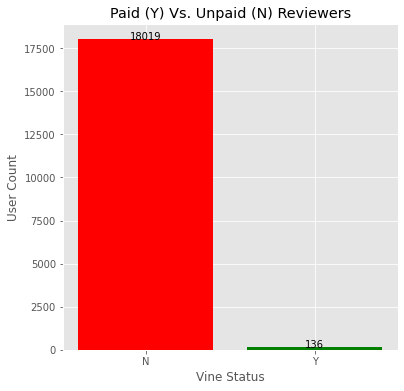

In [47]:
import numpy as np

# creating color list to assign color to each bar
colors = ["r","g"]
# Getting the count of paid and unpaid reviewers useing "barHelpfulDf" Dataframe
pltDf = barHelpfulDf.vine.value_counts()

# Using numpy to use the length of our "pltDf.index" list as x axis positions
# for our bars
x_pos = np.arange(len(pltDf.index))

fig,axs = plt.subplots(figsize=(6,6))

# Creating bar chart
axs.bar(x_pos, pltDf.values, align="center", color=colors)
# Setting x axis bar label position
axs.set_xticks(x_pos)
# Setting x axis bar labels
axs.set_xticklabels(pltDf.index.unique())
# Setting bar chart title
axs.set_title("Paid (Y) Vs. Unpaid (N) Reviewers")
# Setting x axis label
axs.set_xlabel("Vine Status")
# Setting y axis label
axs.set_ylabel("User Count")
# Adding value count to the top of each bar
addlabels(pltDf.index, pltDf.values)

plt.show()

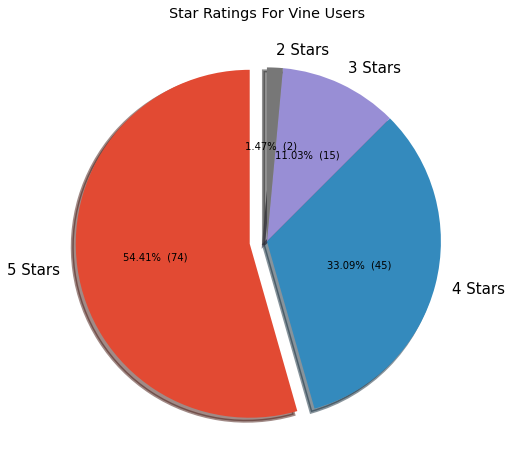

In [48]:
# Function to display pie slice count and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Getting the amount of each star rating for PAID reviewers
pltPaidDf = pdVinePaidDf.star_rating.value_counts()

myLabels = ["5 Stars", "4 Stars", "3 Stars", "2 Stars"]
# Highlighting the 5 star slice by seperating(exploding) it from the pie
explode = (0.1, 0.0, 0.0, 0.0,)


fig, axs = plt.subplots(figsize=(8,8))

_, texts, autotexts = axs.pie(pltPaidDf.values, 
                              explode=explode, 
                              labels=myLabels,
                              startangle = 90, 
                              shadow = True,
                              autopct=make_autopct(pltPaidDf.values),
                              pctdistance=.55,
                              wedgeprops = {'linewidth': 3})

# loop to set color for text of pie slices
for autotext in autotexts:
    autotext.set_color('black')
# Sets font size for slice labels
[ _.set_fontsize(15) for _ in texts ]

# Setting pie chart title
axs.set_title('Star Ratings For Vine Users')

# Displaying pie chart
plt.show()

In [50]:
pltUnpaidDf = pdVineUnpaidDf.star_rating.value_counts()
pltUnpaidDf

5    8482
1    3483
4    3098
3    1680
2    1276
Name: star_rating, dtype: int64

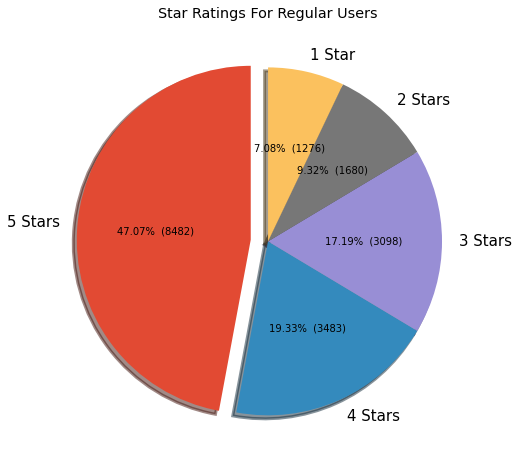

In [59]:
# Function to display pie slice count and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Getting the amount of each star rating for UNPAID reviewers
pltUnpaidDf = pdVineUnpaidDf.star_rating.value_counts()

myLabels = ["5 Stars", "4 Stars", "3 Stars", "2 Stars", "1 Star"]
# Highlighting the 5 star slice by seperating(exploding) it from the pie
explode = (0.1, 0.0, 0.0, 0.0, 0.0)

fig, axs = plt.subplots(figsize=(8,8))
_, texts, autotexts =axs.pie(pltUnpaidDf.values,
                             explode=explode, 
                             labels=myLabels,startangle = 90, 
                             shadow = True,
                             autopct=make_autopct(pltUnpaidDf.values), 
                             pctdistance=.55,
                             wedgeprops = {'linewidth': 3})

# loop to set color for text of pie slices
for autotext in autotexts:
    autotext.set_color('black')

# Sets font size for slice labels   
[ _.set_fontsize(15) for _ in texts ]

# Sets pie chart table
axs.set_title('Star Ratings For Regular Users')

# Displaying pie chart
plt.show()